In [1]:
!pip install -q kaggle
!pip install --upgrade datasets
!pip install -qU seqeval
!pip install evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.9 MB/s eta 0:00:00


In [29]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json

from transformers import AutoTokenizer, BertForTokenClassification
import torch
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split, Dataset
from torch.nn.functional import pad
import torch.nn.functional as F
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from tqdm.auto import tqdm
import evaluate as eval_lib

from collections import Counter


import warnings
warnings.filterwarnings(action="ignore")

In [3]:
pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Data preprocessing

In [4]:
MOUNTAIN_TAG_COLOR = '\33[104m'
O_TAG_COLOR  = '\33[100m'

color_mapping = {'O': O_TAG_COLOR, 'MOUNTAIN': MOUNTAIN_TAG_COLOR}

In [6]:
df = pd.read_csv("MountainsDataset.csv", encoding='unicode_escape')

In [7]:
import ast

# Convert string representations of lists into actual lists if needed
columns_to_check = ['Word', 'POS', 'Tag', 'TagGeneral', 'TagPos', 'TagId']
for column in columns_to_check:
    df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [8]:
def display_formatted_text(words, tags):
    """
    Displays formatted text with color-coding based on tags.

    Args:
        words (list): A list of words to display.
        tags (list): A list of tags corresponding to the words. The tags are used
                     to apply the appropriate color from `color_mapping`.

    Returns:
        None
    """
    formatted_text = " ".join([color_mapping[tag] + word for word, tag in zip(words, tags)]) + O_TAG_COLOR
    print(formatted_text)


# Get the words and tags from the first row of the dataframe and display the formatted text
text = df.loc[0, "Word"]
tags = df.loc[0, "TagGeneral"]
display_formatted_text(text, tags)

# Get the words and tags from the 42nd row of the dataframe and display the formatted text
text = df.loc[42, "Word"]
tags = df.loc[42, "TagGeneral"]
display_formatted_text(text, tags)

A group of climbers is preparing to ascend Mount Ngauruhoe next week .
Climbing Mount Etna is a breathtaking experience that attracts many adventurers .


Tokenizer and Model

In [9]:
huggingface_model = "bert-base-cased"  # Model identifier for the Hugging Face BERT model
tokenizer = AutoTokenizer.from_pretrained(huggingface_model, do_lower_case=True)  # Load the tokenizer for the BERT model with lowercasing
tokenizer.special_tokens_map  # Display the mapping of special tokens (e.g., CLS, SEP, PAD)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [10]:
# Flatten the lists in the 'Tag' column
df_exploded_tag = df.explode('Tag')

# Flatten the lists in the 'TagGeneral' column
df_exploded_tag_general = df.explode('TagGeneral')

# Extract unique tags from the flattened DataFrames
tag_list = df_exploded_tag["Tag"].unique()
tag_general_list = df_exploded_tag_general["TagGeneral"].unique()

# Calculate the number of unique tags
n_tags = len(tag_list)
n_tag_general = len(tag_general_list)

# Create a mapping between tags and IDs
tags2ids = {tag: i for i, tag in enumerate(tag_list)}
ids2tags = {i: tag for i, tag in enumerate(tag_list)}

In [11]:
model = BertForTokenClassification.from_pretrained(
    huggingface_model,  # Pretrained BERT model identifier
    num_labels=n_tags,  # Number of labels/tags for token classification
    output_attentions=False,  # Do not return attention weights
    output_hidden_states=False  # Do not return hidden states
).to(device)  # Move the model to the specified device (e.g., GPU)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dataset & Dataloaders

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    """
    A custom dataset class for token classification tasks.
    It processes input data and creates token-level labels using a tokenizer.

    Args:
        df (DataFrame): A dataframe containing the input words and corresponding tag IDs.
        tokenizer (AutoTokenizer): The tokenizer used to tokenize the input words.
    """
    def __init__(self, df, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.inputs = df["Word"].values  # Input words
        self.labels = df["TagId"].values  # Corresponding tag IDs
        self.len = len(self.labels)  # Length of the dataset

    def __getitem__(self, idx):
        """
        Retrieves a single item (word) from the dataset, tokenizes it,
        and creates the corresponding token labels.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: Tuple containing tokenized input IDs, token type IDs,
                   attention mask, and token labels.
        """
        encoded_dict = self.tokenizer(self.inputs[idx],
                                      is_split_into_words=True,
                                      add_special_tokens=True,
                                      return_attention_mask=True,
                                      return_tensors='pt')

        token_labels = self.__create_token_labels(self.labels[idx], encoded_dict.word_ids())
        return encoded_dict['input_ids'][0], encoded_dict['token_type_ids'][0], encoded_dict['attention_mask'][0], token_labels

    def __create_token_labels(self, labels, word_ids):
        """
        Creates token-level labels that correspond to each token generated by the tokenizer.

        Args:
            labels (list): The list of labels corresponding to the input words.
            word_ids (list): The list of word IDs produced by the tokenizer.

        Returns:
            Tensor: A tensor containing the token-level labels, where non-word tokens (e.g., subwords)
                    are assigned a label of -100 to ignore them during loss computation.
        """
        extended_labels = [-100 if word_id is None else labels[word_id] for word_id in word_ids]
        return torch.tensor(extended_labels).to(torch.int64)

    def __len__(self):
        return self.len

In [13]:
def collate_fn(batch):
    """
    Prepares batches of data for training by padding sequences to the same length.

    Args:
        batch (list of tuples): A batch of data samples, where each sample is a tuple
                                containing input IDs, token type IDs, attention masks,
                                and labels.

    Returns:
        tuple: A tuple containing padded and stacked input IDs, token type IDs,
               attention masks, and labels, all moved to the specified device.
    """
    max_len = max([len(sample[0]) for sample in batch])  # Find the maximum sequence length in the batch

    ids = []
    token_types = []
    attention_masks = []
    labels = []

    for sample in batch:
        pad_length = max_len - len(sample[0])  # Calculate the padding length for each sample
        ids.append(pad(sample[0], (0, pad_length), value=0))  # Pad input IDs with zeros
        token_types.append(pad(sample[1], (0, pad_length), value=0))  # Pad token type IDs with zeros
        attention_masks.append(pad(sample[2], (0, pad_length), value=0))  # Pad attention masks with zeros
        labels.append(pad(sample[3], (0, pad_length), value=-100))  # Pad labels with -100 to ignore during loss computation

    return (torch.stack(ids).to(device),
            torch.stack(token_types).to(device),
            torch.stack(attention_masks).to(device),
            torch.stack(labels).to(device))  # Return padded and stacked tensors, moved to the specified device

In [14]:
dataset = CustomDataset(df, tokenizer)

# Split the dataset into training (80%) and validation (20%) sets
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# Print the number of samples in the training and validation sets
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))

1,163 training samples
  291 validation samples


In [15]:
batch_size = 8

# Create a DataLoader for the training dataset with a random sampler and custom collate function
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),  # Randomly samples the training dataset for each batch
    batch_size=batch_size,  # Number of samples per batch
    collate_fn=collate_fn  # Custom collate function for padding sequences
)

# Create a DataLoader for the validation dataset with a sequential sampler and custom collate function
validation_dataloader = DataLoader(
    validation_dataset,
    sampler=SequentialSampler(validation_dataset),  # Sequentially samples the validation dataset for each batch
    batch_size=batch_size,  # Number of samples per batch
    collate_fn=collate_fn  # Custom collate function for padding sequences
)

Training

In [16]:
EPOCHS = 10

optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8)

# optimizer = optim.SGD(model.parameters(),
#                           lr=0.01,
#                           momentum=0.9,
#                           weight_decay=5e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Initialize lists to store loss values
avg_train_loss = []
avg_val_loss = []

# Early stopping parameters
patience = 2  # Number of epochs to wait after last improvement
best_val_loss = float('inf')
epochs_no_improve = 0

# Save the model's state when it achieves the best validation loss
best_model_state = None

In [17]:
for epoch_i in range(EPOCHS):
    running_train_loss = 0.0
    running_val_loss = 0.0

    model.train()  # Set the model to training mode

    # Training loop with progress bar
    loop = tqdm(train_dataloader, desc=f"Training. Epoch [{epoch_i+1}/{EPOCHS}]")

    for batch in loop:
        optimizer.zero_grad()  # Reset gradients
        output = model(input_ids=batch[0],  # Forward pass
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])
        loss = output.loss
        running_train_loss += loss.item()  # Accumulate the training loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        loop.set_description(f"Training. Epoch [{epoch_i+1}/{EPOCHS}]. Loss {loss.item()}")  # Update progress bar

    # Calculate the average training loss for this epoch
    avg_epoch_train_loss = running_train_loss / train_size
    avg_train_loss.append(avg_epoch_train_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        loop = tqdm(validation_dataloader, desc=f"Validation. Epoch [{epoch_i+1}/{EPOCHS}]")
        for batch in loop:
            output = model(input_ids=batch[0],  # Forward pass
                           token_type_ids=batch[1],
                           attention_mask=batch[2],
                           labels=batch[3])
            loss = output.loss
            running_val_loss += loss.item()  # Accumulate validation loss
            loop.set_description(f"Validation. Epoch [{epoch_i+1}/{EPOCHS}]. Loss {loss.item()}")  # Update progress bar

    # Calculate the average validation loss for this epoch
    avg_epoch_val_loss = running_val_loss / validation_size
    avg_val_loss.append(avg_epoch_val_loss)

    # Check if validation loss has improved
    if avg_epoch_val_loss < best_val_loss:
        best_val_loss = avg_epoch_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save the best model state
        print(f"Validation loss decreased. Saving model...")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

    # Check if early stopping should be triggered
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch_i+1} epochs.")
        model.load_state_dict(best_model_state)  # Load the best model state before exiting
        break

    scheduler.step()  # Update the learning rate


Training. Epoch [1/10]:   0%|          | 0/146 [00:00<?, ?it/s]

Validation. Epoch [1/10]:   0%|          | 0/37 [00:00<?, ?it/s]

Validation loss decreased. Saving model...


Training. Epoch [2/10]:   0%|          | 0/146 [00:00<?, ?it/s]

Validation. Epoch [2/10]:   0%|          | 0/37 [00:00<?, ?it/s]

No improvement in validation loss for 1 epoch(s).


Training. Epoch [3/10]:   0%|          | 0/146 [00:00<?, ?it/s]

Validation. Epoch [3/10]:   0%|          | 0/37 [00:00<?, ?it/s]

No improvement in validation loss for 2 epoch(s).
Early stopping triggered after 3 epochs.


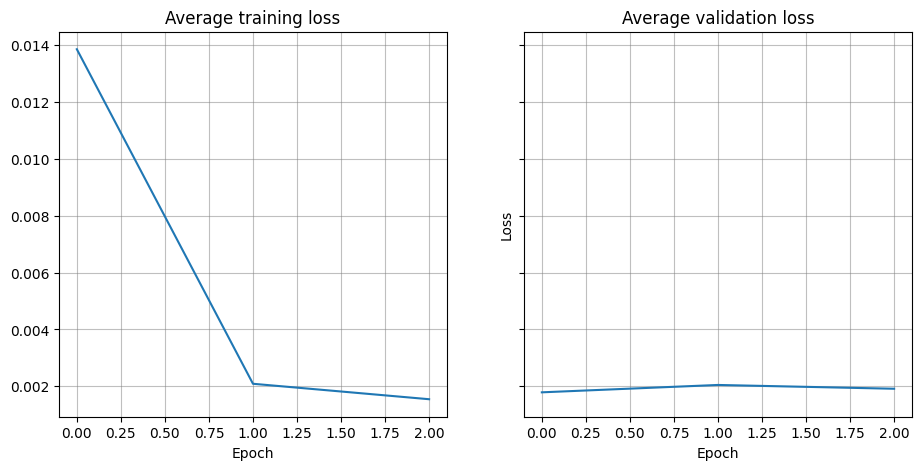

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5), sharex=True, sharey=True)

axs[0].plot(avg_train_loss)
axs[0].set_title("Average training loss")

axs[1].plot(avg_val_loss)
axs[1].set_title("Average validation loss")

axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

for ax in axs:
    ax.grid(c='gray', alpha=0.5)

Evaluate

In [19]:
def evaluate(model, dataloader):
    """
    Evaluates the performance of a model using the seqeval metric.

    Args:
        model (nn.Module): The trained model to evaluate.
        dataloader (DataLoader): The dataloader containing the evaluation dataset.

    Returns:
        dict: A dictionary containing the evaluation metric results, such as precision, recall, and F1 score.
    """
    metric = eval_lib.load("seqeval")  # Load the seqeval metric for evaluation

    all_predictions = []  # List to store all predictions
    all_labels = []  # List to store all true labels

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in dataloader:
            output = model(input_ids=batch[0],  # Forward pass
                           token_type_ids=batch[1],
                           attention_mask=batch[2],
                           labels=batch[3])
            labels = batch[3].to('cpu').numpy()  # Move true labels to CPU and convert to numpy
            predictions = torch.argmax(output.logits.detach().cpu(), 2).numpy()  # Get the predicted labels

            # Collect predictions and true labels, ignoring -100 labels used for padding
            for prediction, label in zip(predictions, labels):
                for pred_idx, label_idx in zip(prediction, label):
                    if label_idx != -100:  # Ignore padding tokens
                        all_predictions.append(ids2tags[pred_idx])  # Convert predicted IDs to tags
                        all_labels.append(ids2tags[label_idx])  # Convert true label IDs to tags

    # Compute the evaluation metrics
    return metric.compute(predictions=[all_predictions], references=[all_labels])

In [20]:
evaluate(model, train_dataloader)

{'MOUNTAIN': {'precision': 0.993002915451895,
  'recall': 0.9843930635838151,
  'f1': 0.9886792452830189,
  'number': 1730},
 'overall_precision': 0.993002915451895,
 'overall_recall': 0.9843930635838151,
 'overall_f1': 0.9886792452830189,
 'overall_accuracy': 0.9970193740685543}

In [21]:
evaluate(model, validation_dataloader)

{'MOUNTAIN': {'precision': 0.9907834101382489,
  'recall': 0.9772727272727273,
  'f1': 0.9839816933638444,
  'number': 440},
 'overall_precision': 0.9907834101382489,
 'overall_recall': 0.9772727272727273,
 'overall_f1': 0.9839816933638444,
 'overall_accuracy': 0.9954624781849912}

Save model

In [22]:
model.save_pretrained("ner_model")
tokenizer.save_pretrained("tokenizer")

config = json.load(open("ner_model/config.json"))
config["id2label"] = ids2tags
config["label2id"] = tags2ids
json.dump(config, open("ner_model/config.json","w"))

Predict tags using hand-made function

In [23]:
def get_predicted_tag(word, tags, scores):
    """
    Determines the predicted tag for a given word by finding the most common tag
    among the provided tags and calculating a score for it.

    Args:
        word (str): The word for which the tag is being predicted.
        tags (list): A list of predicted tags for each token in the word.
        scores (list): A list of confidence scores for each predicted tag.

    Returns:
        dict: A dictionary with the word, the predicted entity group, and the confidence score.
    """
    # Use Counter() to find the most common tag in the list.
    most_common_tag = Counter(tags).most_common()[0][0]
    # Adjust the Scores Based on the Most Common Tag
    correct_scores = [score if tag == most_common_tag else -score for score, tag in zip(scores, tags)]
    # Avarage these adjusted scores to provide an overall confidence score for the word's predicted tag.
    score = round(sum(correct_scores) / len(correct_scores), 4)
    # Convert the most common tag(B-MOUNTAIN) into the actual entity type(MOUNTAIN)
    predicted_tag = ids2tags[most_common_tag].split("-")[-1]
    return {"word": word, "entity_group": predicted_tag, "score": score}

In [27]:
def predict(raw_text, display_formatted_text=True):
    """
    Predicts entity tags for each word in the input text using a token classification model.

    Args:
        raw_text (str): The input text to be tokenized and processed.
        display_formatted_text (bool, optional): If True, prints the formatted text with entity colors. Defaults to True.

    Returns:
        list: A list of dictionaries, where each dictionary contains the word, predicted entity group, and score.
    """
    # Split text into words while preserving newlines
    tokens_with_newlines = re.findall(r'\S+|\n', raw_text)
    tokens = []
    newlines_positions = []
    for idx, token in enumerate(tokens_with_newlines):
        if token == '\n':
            newlines_positions.append(idx)
        else:
            tokens.append(token)

    # Tokenize the text
    encoded_dict = tokenizer(tokens,
                             is_split_into_words=True,
                             add_special_tokens=True,
                             return_attention_mask=True,
                             return_tensors='pt')

    # Extract the tokenized input sequence and add an extra dimension for compatibility
    # with batch processing in the model.
    input_ids = encoded_dict['input_ids'][0].unsqueeze(0).to(device)
    input_token_type = encoded_dict['token_type_ids'][0].unsqueeze(0).to(device)
    input_mask = encoded_dict['attention_mask'][0].unsqueeze(0).to(device)

    # Forward pass
    output = model(input_ids,
                   token_type_ids=input_token_type,
                   attention_mask=input_mask)
    # Convert logits into a probabilities
    normalized_output = F.softmax(output.logits.detach().cpu(), dim=2)
    # Extract the predicted class for each token
    predictions = torch.max(normalized_output, 2)
    # Flatten the predictions and probabilities into simple lists
    predicted_labels = predictions.indices.numpy().flatten()
    predicted_scores = predictions.values.numpy().flatten()

    result = []
    prev_token_id = None

    # Process the predicted labels and scores
    for token_id, predicted_label, score in zip(encoded_dict.word_ids(), predicted_labels, predicted_scores):
        # Skip if it is a special or a padding token
        if token_id is None:
            continue
        # Check if it IS a new word
        elif token_id != prev_token_id:
            if prev_token_id is not None:
                # Process all the predictions for the subword tokens of the previous word
                result.append(get_predicted_tag(tokens[prev_token_id], tags, scores))
            tags = []
            scores = []

        tags.append(predicted_label)
        scores.append(score)
        prev_token_id = token_id

    # Append the last token
    if prev_token_id is not None:
        result.append(get_predicted_tag(tokens[prev_token_id], tags, scores))

    # Display the formatted text with entity colors
    if display_formatted_text:
        formatted_text_parts = []
        for idx, entity in enumerate(result):
            if idx in newlines_positions:
                formatted_text_parts.append('\n')
            color = color_mapping.get(entity["entity_group"], "")
            formatted_text_parts.append(color + entity["word"] + O_TAG_COLOR)
        formatted_text = " ".join(formatted_text_parts)
        print(formatted_text)
        print()

    return result

In [30]:
text = """Mount Kilimanjaro stands as the tallest peak in Africa, drawing adventurers from around the world.
          Its snow-capped summit contrasts beautifully with the surrounding savannah, offering breathtaking views
          for those who make the climb. As hikers ascend through its various climate zones, they experience everything
          from tropical rainforests to alpine deserts. The journey to the top is both physically demanding and mentally
          challenging, but the reward of standing on the roof of Africa is unforgettable. For many, reaching Kilimanjaro’s
          summit is a once-in-a-lifetime achievement."""
predict(text)

Mount Kilimanjaro stands as the tallest peak in Africa, drawing adventurers from around the world. 
 Its snow-capped summit contrasts beautifully with the surrounding savannah, offering breathtaking views for 
 those who make the climb. As hikers ascend through its various climate zones, they experience everything from tropical 
 rainforests to alpine deserts. The journey to the top is both physically demanding and mentally challenging, but the 
 reward of standing on the roof of Africa is unforgettable. For many, reaching Kilimanjaro’s summit is a once-in-a-lifetime 
 achievement.



[{'word': 'Mount', 'entity_group': 'MOUNTAIN', 'score': 0.9997},
 {'word': 'Kilimanjaro', 'entity_group': 'MOUNTAIN', 'score': 0.9998},
 {'word': 'stands', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'as', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'tallest', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'peak', 'entity_group': 'O', 'score': 0.9994},
 {'word': 'in', 'entity_group': 'O', 'score': 0.9996},
 {'word': 'Africa,', 'entity_group': 'O', 'score': 0.9718},
 {'word': 'drawing', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'adventurers', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'from', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'around', 'entity_group': 'O', 'score': 0.9997},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'world.', 'entity_group': 'O', 'score': 0.9997},
 {'word': 'Its', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'snow-capped', 'entity_group': 'O', 'scor